# Testbed

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cp -a -n /content/drive/MyDrive/wordle-rl/. /content/
! mkdir /content/drive/MyDrive/wordle-rl/tests

cp: cannot stat '/content/drive/MyDrive/wordle-rl/./tests': No such file or directory


In [3]:
! pip install cpprb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 43.5 MB/s eta 0:00:00


In [4]:
%load_ext autoreload
%autoreload 2

from functools import partial
from collections import defaultdict
import pickle

from wordle.wordlenp import Wordle
from environment.environment import Environment, StateYesNo, StateVocabulary, ActionVocabulary
from dqn.cpprb_agent import Agent
from dqn.train import train, test
from replay_buffer.cpprb import PrioritizedReplayBuffer, ReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import torch
import numpy as np
np.random.seed(0)

## Датасеты

In [5]:
word_list = Wordle._load_vocabulary('wordle/guesses.txt', astype=np.array)

def make_data(n_answers, n_guesses):
    guesses = np.random.choice(word_list, size=n_guesses, replace=False)
    answers = np.random.choice(guesses, size=n_answers, replace=False)
    return answers, guesses

### 10 answers, 100 guesses

In [6]:
answers_10_100, guesses_10_100 = make_data(10, 100)
print(answers_10_100)

['abmho' 'cites' 'aware' 'blays' 'acker' 'rawin' 'anile' 'eorls' 'feers'
 'sadza']


### 100 answers, 100 guesses

In [7]:
answers_100_100, guesses_100_100 = make_data(100, 100)
print(answers_100_100)

['lilac' 'orles' 'twirl' 'unled' 'sings' 'grind' 'sheaf' 'benny' 'slews'
 'karst' 'rimus' 'lossy' 'joker' 'leash' 'scopa' 'viols' 'giron' 'raiks'
 'lummy' 'renig' 'tinds' 'infos' 'logon' 'drill' 'gudes' 'ammon' 'bhoot'
 'hurry' 'noils' 'coven' 'beryl' 'margs' 'sorbo' 'momes' 'scald' 'potch'
 'flows' 'torus' 'prill' 'scuts' 'brith' 'tamin' 'sewar' 'joram' 'aldol'
 'hazel' 'texes' 'sibbs' 'truth' 'spoil' 'hames' 'actin' 'maces' 'rayas'
 'thuya' 'sugan' 'felly' 'newsy' 'bolos' 'mimeo' 'chems' 'dicty' 'liefs'
 'scuff' 'burps' 'abyes' 'zones' 'cuspy' 'kerve' 'haith' 'amino' 'zygal'
 'kokum' 'zambo' 'icier' 'piers' 'sambo' 'laden' 'barge' 'solei' 'mauts'
 'groat' 'pearl' 'curse' 'jujus' 'troop' 'bilge' 'sibyl' 'gassy' 'elain'
 'daube' 'feyly' 'duals' 'hoper' 'hains' 'beige' 'poove' 'miffy' 'lesbo'
 'dawds']


### 50 answers, 200 guesses

In [8]:
answers_50_200, guesses_50_200 = make_data(50, 200)
print(answers_50_200)

['toran' 'burka' 'umpie' 'brock' 'civic' 'beige' 'hoiks' 'biffo' 'nagas'
 'sheol' 'malls' 'matzo' 'peeve' 'deshi' 'mooli' 'scaud' 'ameba' 'wadds'
 'bayts' 'glees' 'kaput' 'bitos' 'comae' 'dosed' 'rabis' 'neats' 'tutti'
 'stays' 'smoky' 'chase' 'resaw' 'simas' 'sowne' 'rorid' 'rebec' 'deawy'
 'hinny' 'sores' 'cerge' 'yogas' 'fouet' 'wheel' 'sowfs' 'talus' 'yabas'
 'topee' 'sabin' 'unbox' 'dyers' 'qophs']


### 300 answers, 300 guesses

In [9]:
answers_300_300, guesses_300_300 = make_data(300, 300)
print(answers_300_300)

['hoied' 'aarti' 'dyers' 'ingot' 'hasty' 'tices' 'tache' 'deoxy' 'sutta'
 'score' 'fiefs' 'sling' 'ready' 'wests' 'dobes' 'tells' 'bitts' 'roper'
 'veena' 'hewer' 'chats' 'jarta' 'ceric' 'olent' 'feare' 'bodge' 'fleer'
 'prats' 'spiny' 'tryps' 'welts' 'march' 'jelly' 'furor' 'okapi' 'penni'
 'curve' 'altar' 'aboon' 'salut' 'amido' 'razor' 'vouch' 'prill' 'ganev'
 'dukka' 'noxal' 'briar' 'wills' 'trigo' 'dusts' 'meter' 'veale' 'hafiz'
 'dosha' 'wilis' 'ohmic' 'silds' 'giust' 'blimy' 'zerda' 'mucus' 'abrin'
 'nandu' 'larva' 'cruds' 'kaies' 'hussy' 'dolce' 'birch' 'madam' 'chase'
 'onely' 'molys' 'scape' 'sauce' 'amate' 'mohur' 'vagal' 'royne' 'spics'
 'azuki' 'acres' 'shops' 'sicks' 'sunup' 'cosey' 'louse' 'aweel' 'skosh'
 'twoer' 'loves' 'wents' 'reest' 'winna' 'rosed' 'mbira' 'rangy' 'omega'
 'moira' 'typey' 'romal' 'bachs' 'floss' 'scath' 'roast' 'moola' 'moles'
 'witch' 'rabbi' 'chest' 'aulos' 'yokes' 'aspen' 'sepic' 'lirot' 'lemon'
 'musts' 'drouk' 'kudzu' 'yacka' 'sonny' 'hived' 'l

### 100 answers, 2000 guesses

In [10]:
answers_100_2000, guesses_100_2000 = make_data(100, 2000)
print(answers_100_2000)

['fumed' 'rival' 'zizit' 'wests' 'scrog' 'gryce' 'seils' 'sugar' 'glims'
 'pharm' 'pyets' 'kilts' 'bings' 'emyde' 'duads' 'shahs' 'spaza' 'spore'
 'redub' 'sidas' 'choco' 'woofs' 'sukuk' 'spumy' 'mirex' 'sluse' 'tween'
 'nodus' 'wands' 'unled' 'rates' 'toxin' 'lotes' 'wacko' 'ariot' 'baisa'
 'sways' 'roads' 'poked' 'popsy' 'gonif' 'vutty' 'bicep' 'parky' 'braid'
 'ports' 'spyal' 'match' 'spook' 'scowp' 'sdein' 'lovie' 'torii' 'souks'
 'vibey' 'genny' 'clues' 'decaf' 'diced' 'delay' 'mirly' 'flogs' 'lotos'
 'whine' 'seems' 'jerry' 'scram' 'gosse' 'roped' 'pipis' 'spank' 'seder'
 'doorn' 'evict' 'buteo' 'ponks' 'miffy' 'potin' 'rathe' 'papaw' 'local'
 'tolus' 'apode' 'jouks' 'decad' 'temes' 'wafts' 'liter' 'kagos' 'piste'
 'ogmic' 'fyles' 'brace' 'adage' 'hepar' 'bales' 'molal' 'eject' 'seles'
 'commy']


## Plotting Utility

In [11]:
def plot_results(tasks_results, figname):
    n_tasks = len(tasks_results)
    _, ax = plt.subplots(1, n_tasks, figsize=(4*n_tasks, 5))
    
    # over tasks
    for i, (task_name, results) in enumerate(tasks_results.items()):
        # over methods
        for method_name, (timers, win_rates) in results.items():
            ax[i].plot(timers, win_rates, label=method_name)
        ax[i].set_xlabel('time, s')
        ax[i].set_ylabel('win rate, s')
        ax[i].legend()
        ax[i].set_title(task_name)
    plt.savefig(figname + '.svg', bbox_inches='tight')
    plt.show()

## Replay Sampling

In [15]:
soft_rewards = {'B':1, 'Y':2, 'G':3, 'win':20, 'lose':-10, 'step':-4}
hard_rewards = {'B':0, 'Y':0, 'G':0, 'win':10, 'lose':-10, 'step':-2}
step_rewards = {'B':0, 'Y':1, 'G':1, 'win':10, 'lose':-10, 'step':-5}
char_rewards = {'B':0, 'Y':1, 'G':1, 'win':10, 'lose':-10, 'step':-2}

In [63]:
tasks_results = defaultdict(dict)

### Uniform

In [68]:
def experiment(answers, guesses, n_episodes, n_warm=500, logging_level=None):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        state_instance=StateVocabulary(
            answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
        )
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=ReplayBuffer(state_size=env.state.size),
        n_warm=n_warm
    )

    res = train(
        env=env, agent=agent, nickname='uniform',
        n_episodes=n_episodes, logging_level=logging_level
    )
    test(env=env, agent=agent)
    return res

In [69]:
res = experiment(answers_10_100, guesses_10_100, 5000)
tasks_results['10/100']['uniform'] = res

Playing 500 initial games (warm start)... Collected! Time: 5.1 s

Episode  500	Score: -4.98	Success Rate: 74.8%	RMSE: 16.799	Time: 8.5 s

Episode 1000	Score: 6.32	Success Rate: 99.4%	RMSE: 16.397	Time: 10.7 s

Episode 1500	Score: 6.55	Success Rate: 99.6%	RMSE: 18.610	Time: 12.9 s

Episode 2000	Score: 7.10	Success Rate: 100.0%	RMSE: 14.558	Time: 15.2 s

Episode 2500	Score: 7.05	Success Rate: 100.0%	RMSE: 12.715	Time: 18.1 s

Episode 3000	Score: 6.58	Success Rate: 99.2%	RMSE: 10.766	Time: 20.9 s

Episode 3500	Score: 6.56	Success Rate: 99.2%	RMSE: 10.926	Time: 23.3 s

Episode 4000	Score: 6.79	Success Rate: 99.8%	RMSE: 10.383	Time: 25.5 s

Episode 4500	Score: 6.73	Success Rate: 99.2%	RMSE: 8.216	Time: 28.5 s

Episode 5000	Score: 6.80	Success Rate: 99.6%	RMSE: 7.937	Time: 32.6 s

Saving checkpoint... Saved to uniform-1-21-03-2023-03:42:34.pth

Success: 10 / 10 (100.0000%)	Steps: 2.2000	Time: 0.0 s	Saved to: test21-03-2023-03:43:07.txt



In [70]:
res = experiment(answers_100_100, guesses_100_100, 20000)
tasks_results['100/100']['uniform'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.2 s

Episode 2000	Score: -25.48	Success Rate: 16.9%	RMSE: 40.974	Time: 31.3 s

Episode 4000	Score: -21.74	Success Rate: 27.9%	RMSE: 38.683	Time: 58.9 s

Saving checkpoint... Saved to uniform-1-21-03-2023-03:43:07.pth

Episode 6000	Score: -18.95	Success Rate: 35.9%	RMSE: 29.772	Time: 84.9 s

Episode 8000	Score: -17.26	Success Rate: 40.9%	RMSE: 41.140	Time: 108.2 s

Episode 10000	Score: -14.22	Success Rate: 50.2%	RMSE: 41.650	Time: 129.9 s

Saving checkpoint... Saved to uniform-2-21-03-2023-03:43:07.pth

Episode 12000	Score: -12.10	Success Rate: 56.4%	RMSE: 39.028	Time: 150.6 s

Episode 14000	Score: -9.65	Success Rate: 64.4%	RMSE: 40.784	Time: 169.1 s

Saving checkpoint... Saved to uniform-3-21-03-2023-03:43:07.pth

Episode 16000	Score: -7.61	Success Rate: 69.3%	RMSE: 37.369	Time: 187.7 s

Episode 18000	Score: -6.71	Success Rate: 72.1%	RMSE: 31.603	Time: 206.2 s

Episode 20000	Score: -4.01	Success Rate: 78.8%	RMSE: 30.323	Time:

In [71]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [72]:
res = experiment(answers_300_300, guesses_300_300, 30000, n_warm=1500)
tasks_results['300/300']['uniform'] = res

Playing 1500 initial games (warm start)... Collected! Time: 13.9 s

Episode 3000	Score: -30.50	Success Rate: 3.6%	RMSE: 18.005	Time: 54.0 s

Saving checkpoint... Saved to uniform-1-21-03-2023-03:46:51.pth

Episode 6000	Score: -29.71	Success Rate: 4.5%	RMSE: 20.677	Time: 95.4 s

Episode 9000	Score: -29.00	Success Rate: 6.3%	RMSE: 29.335	Time: 136.6 s

Saving checkpoint... Saved to uniform-2-21-03-2023-03:46:51.pth

Episode 12000	Score: -28.49	Success Rate: 7.7%	RMSE: 25.879	Time: 177.6 s

Episode 15000	Score: -28.13	Success Rate: 8.6%	RMSE: 22.004	Time: 220.0 s

Saving checkpoint... Saved to uniform-3-21-03-2023-03:46:51.pth

Episode 18000	Score: -28.09	Success Rate: 8.7%	RMSE: 23.368	Time: 262.0 s

Saving checkpoint... Saved to uniform-4-21-03-2023-03:46:51.pth

Episode 21000	Score: -26.58	Success Rate: 13.3%	RMSE: 32.475	Time: 302.3 s

Episode 24000	Score: -26.15	Success Rate: 14.4%	RMSE: 33.903	Time: 342.8 s

Saving checkpoint... Saved to uniform-5-21-03-2023-03:46:51.pth

Episode 27

In [73]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [74]:
res = experiment(answers_100_2000, guesses_100_2000, 40000, n_warm=3000)
tasks_results['100/2000']['uniform'] = res

Playing 3000 initial games (warm start)... Collected! Time: 32.6 s

Episode 4000	Score: -32.09	Success Rate: 0.2%	RMSE: 263.052	Time: 92.8 s

Saving checkpoint... Saved to uniform-1-21-03-2023-03:53:56.pth

Episode 8000	Score: -31.89	Success Rate: 0.2%	RMSE: 34.869	Time: 155.3 s

Saving checkpoint... Saved to uniform-2-21-03-2023-03:53:56.pth

Episode 12000	Score: -33.01	Success Rate: 0.2%	RMSE: 30.056	Time: 218.0 s

Saving checkpoint... Saved to uniform-3-21-03-2023-03:53:56.pth

Episode 16000	Score: -33.50	Success Rate: 0.1%	RMSE: 21.079	Time: 279.6 s

Episode 20000	Score: -33.57	Success Rate: 0.0%	RMSE: 29.491	Time: 342.0 s

Saving checkpoint... Saved to uniform-4-21-03-2023-03:53:56.pth

Episode 24000	Score: -33.49	Success Rate: 0.0%	RMSE: 35.694	Time: 403.1 s

Saving checkpoint... Saved to uniform-5-21-03-2023-03:53:56.pth

Episode 28000	Score: -33.42	Success Rate: 0.1%	RMSE: 33.989	Time: 465.3 s

Saving checkpoint... Saved to uniform-6-21-03-2023-03:53:56.pth

Episode 32000	Score

/content/dqn/train.py:185: RuntimeWarning: Mean of empty slice.
  f'Steps: {steps[success.astype(bool)].mean():.4f}',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [75]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

### A Little Prioritized

In [76]:
def experiment(answers, guesses, n_episodes, logging_level=None, n_warm=500):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        state_instance=StateVocabulary(
            answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
        )
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=PrioritizedReplayBuffer(
            state_size=env.state.size,
            alpha=0.1, beta=0.9,
            beta_growth_rate=1.05
        ),
        n_warm=n_warm
    )

    res = train(
        env=env, agent=agent, nickname='little',
        n_episodes=n_episodes, logging_level=logging_level
    )
    test(env=env, agent=agent)
    return res

In [77]:
res = experiment(answers_10_100, guesses_10_100, 5000)
tasks_results['10/100']['little'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.4 s

Episode  500	Score: -6.23	Success Rate: 72.2%	RMSE: 167.232	Time: 8.5 s

Episode 1000	Score: 6.26	Success Rate: 99.8%	RMSE: 107.947	Time: 11.3 s

Episode 1500	Score: 6.82	Success Rate: 100.0%	RMSE: 117.564	Time: 13.5 s

Episode 2000	Score: 7.06	Success Rate: 100.0%	RMSE: 99.782	Time: 15.6 s

Episode 2500	Score: 6.96	Success Rate: 99.8%	RMSE: 103.577	Time: 17.8 s

Episode 3000	Score: 7.06	Success Rate: 100.0%	RMSE: 104.941	Time: 19.9 s

Episode 3500	Score: 6.68	Success Rate: 99.6%	RMSE: 89.580	Time: 22.7 s

Episode 4000	Score: 6.47	Success Rate: 98.8%	RMSE: 81.978	Time: 25.3 s

Episode 4500	Score: 6.02	Success Rate: 98.2%	RMSE: 95.162	Time: 27.6 s

Episode 5000	Score: 6.81	Success Rate: 99.8%	RMSE: 109.435	Time: 29.7 s

Saving checkpoint... Saved to little-1-21-03-2023-04:04:49.pth

Success: 10 / 10 (100.0000%)	Steps: 2.7000	Time: 0.0 s	Saved to: test21-03-2023-04:05:19.txt



In [78]:
res = experiment(answers_100_100, guesses_100_100, 20000)
tasks_results['100/100']['little'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.4 s

Episode 2000	Score: -26.76	Success Rate: 14.0%	RMSE: 202.116	Time: 29.5 s

Episode 4000	Score: -23.50	Success Rate: 22.6%	RMSE: 230.657	Time: 54.6 s

Saving checkpoint... Saved to little-1-21-03-2023-04:05:19.pth

Episode 6000	Score: -20.95	Success Rate: 30.2%	RMSE: 293.987	Time: 79.7 s

Episode 8000	Score: -17.76	Success Rate: 39.7%	RMSE: 303.914	Time: 103.3 s

Episode 10000	Score: -16.10	Success Rate: 45.5%	RMSE: 285.872	Time: 125.4 s

Saving checkpoint... Saved to little-2-21-03-2023-04:05:19.pth

Episode 12000	Score: -14.15	Success Rate: 50.4%	RMSE: 309.886	Time: 147.9 s

Episode 14000	Score: -12.25	Success Rate: 56.3%	RMSE: 309.381	Time: 169.2 s

Saving checkpoint... Saved to little-3-21-03-2023-04:05:19.pth

Episode 16000	Score: -9.25	Success Rate: 63.8%	RMSE: 296.213	Time: 189.1 s

Episode 18000	Score: -8.40	Success Rate: 66.6%	RMSE: 283.565	Time: 208.4 s

Episode 20000	Score: -7.16	Success Rate: 69.5%	RMSE: 229.1

In [79]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [80]:
res = experiment(answers_300_300, guesses_300_300, 30000, n_warm=1500)
tasks_results['300/300']['little'] = res

Playing 1500 initial games (warm start)... Collected! Time: 14.9 s

Episode 3000	Score: -31.21	Success Rate: 2.1%	RMSE: 194.200	Time: 57.6 s

Saving checkpoint... Saved to little-1-21-03-2023-04:09:08.pth

Episode 6000	Score: -30.15	Success Rate: 3.6%	RMSE: 237.953	Time: 100.9 s

Episode 9000	Score: -29.79	Success Rate: 4.2%	RMSE: 204.755	Time: 144.2 s

Saving checkpoint... Saved to little-2-21-03-2023-04:09:08.pth

Episode 12000	Score: -29.28	Success Rate: 5.3%	RMSE: 178.803	Time: 187.2 s

Episode 15000	Score: -28.75	Success Rate: 6.6%	RMSE: 210.500	Time: 230.1 s

Saving checkpoint... Saved to little-3-21-03-2023-04:09:08.pth

Episode 18000	Score: -28.57	Success Rate: 7.2%	RMSE: 287.019	Time: 273.5 s

Saving checkpoint... Saved to little-4-21-03-2023-04:09:08.pth

Episode 21000	Score: -28.01	Success Rate: 9.1%	RMSE: 183.584	Time: 316.2 s

Episode 24000	Score: -27.13	Success Rate: 11.5%	RMSE: 205.766	Time: 358.2 s

Saving checkpoint... Saved to little-5-21-03-2023-04:09:08.pth

Episode

In [81]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [82]:
res = experiment(answers_100_2000, guesses_100_2000, 40000, n_warm=3000)
tasks_results['100/2000']['little'] = res

Playing 3000 initial games (warm start)... Collected! Time: 32.7 s

Episode 4000	Score: -31.81	Success Rate: 0.2%	RMSE: 533.925	Time: 95.6 s

Saving checkpoint... Saved to little-1-21-03-2023-04:16:34.pth

Episode 8000	Score: -32.37	Success Rate: 0.3%	RMSE: 172.487	Time: 158.8 s

Saving checkpoint... Saved to little-2-21-03-2023-04:16:34.pth

Episode 12000	Score: -33.31	Success Rate: 0.1%	RMSE: 217.628	Time: 222.7 s

Saving checkpoint... Saved to little-3-21-03-2023-04:16:34.pth

Episode 16000	Score: -33.06	Success Rate: 0.2%	RMSE: 272.914	Time: 286.2 s

Episode 20000	Score: -32.96	Success Rate: 0.2%	RMSE: 208.154	Time: 349.4 s

Saving checkpoint... Saved to little-4-21-03-2023-04:16:34.pth

Episode 24000	Score: -32.79	Success Rate: 0.1%	RMSE: 248.029	Time: 412.4 s

Saving checkpoint... Saved to little-5-21-03-2023-04:16:34.pth

Episode 28000	Score: -32.75	Success Rate: 0.3%	RMSE: 252.041	Time: 475.9 s

Saving checkpoint... Saved to little-6-21-03-2023-04:16:34.pth

Episode 32000	Score

/content/dqn/train.py:185: RuntimeWarning: Mean of empty slice.
  f'Steps: {steps[success.astype(bool)].mean():.4f}',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [83]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

### Middle Prioritized

In [84]:
def experiment(answers, guesses, n_episodes, logging_level=None, n_warm=500):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        state_instance=StateVocabulary(
            answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
        )
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=PrioritizedReplayBuffer(
            state_size=env.state.size,
            alpha=0.4, beta=0.9,
            beta_growth_rate=1.007
        ),
        n_warm=n_warm
    )

    res = train(
        env=env, agent=agent, nickname='middle',
        n_episodes=n_episodes, logging_level=logging_level
    )
    test(env=env, agent=agent)
    return res

In [85]:
res = experiment(answers_10_100, guesses_10_100, 5000)
tasks_results['10/100']['middle'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.4 s

Episode  500	Score: -6.87	Success Rate: 71.4%	RMSE: 105.104	Time: 9.4 s

Episode 1000	Score: 4.56	Success Rate: 96.6%	RMSE: 147.263	Time: 11.9 s

Episode 1500	Score: 6.78	Success Rate: 100.0%	RMSE: 130.129	Time: 14.1 s

Episode 2000	Score: 7.02	Success Rate: 100.0%	RMSE: 97.114	Time: 16.1 s

Episode 2500	Score: 7.15	Success Rate: 100.0%	RMSE: 113.635	Time: 18.2 s

Episode 3000	Score: 7.11	Success Rate: 100.0%	RMSE: 93.896	Time: 20.9 s

Episode 3500	Score: 7.17	Success Rate: 100.0%	RMSE: 67.322	Time: 23.3 s

Episode 4000	Score: 6.85	Success Rate: 99.6%	RMSE: 72.459	Time: 25.4 s

Episode 4500	Score: 7.07	Success Rate: 100.0%	RMSE: 69.136	Time: 27.6 s

Episode 5000	Score: 6.53	Success Rate: 99.2%	RMSE: 91.919	Time: 29.8 s

Saving checkpoint... Saved to middle-1-21-03-2023-04:27:41.pth

Success: 10 / 10 (100.0000%)	Steps: 1.9000	Time: 0.0 s	Saved to: test21-03-2023-04:28:11.txt



In [86]:
res = experiment(answers_100_100, guesses_100_100, 20000)
tasks_results['100/100']['middle'] = res

Playing 500 initial games (warm start)... Collected! Time: 5.0 s

Episode 2000	Score: -26.85	Success Rate: 12.8%	RMSE: 179.846	Time: 29.9 s

Episode 4000	Score: -23.14	Success Rate: 23.5%	RMSE: 230.242	Time: 54.7 s

Saving checkpoint... Saved to middle-1-21-03-2023-04:28:11.pth

Episode 6000	Score: -18.41	Success Rate: 37.1%	RMSE: 304.490	Time: 78.1 s

Episode 8000	Score: -15.61	Success Rate: 45.9%	RMSE: 313.018	Time: 100.7 s

Episode 10000	Score: -12.10	Success Rate: 55.8%	RMSE: 242.716	Time: 120.7 s

Saving checkpoint... Saved to middle-2-21-03-2023-04:28:11.pth

Episode 12000	Score: -8.68	Success Rate: 64.5%	RMSE: 316.267	Time: 139.7 s

Episode 14000	Score: -6.38	Success Rate: 70.9%	RMSE: 312.407	Time: 157.5 s

Saving checkpoint... Saved to middle-3-21-03-2023-04:28:11.pth

Episode 16000	Score: -3.25	Success Rate: 78.3%	RMSE: 350.311	Time: 173.5 s

Episode 18000	Score: -2.39	Success Rate: 81.0%	RMSE: 298.721	Time: 189.2 s

Episode 20000	Score: -2.23	Success Rate: 81.0%	RMSE: 348.604

In [87]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [88]:
res = experiment(answers_300_300, guesses_300_300, 30000, n_warm=1500)
tasks_results['300/300']['middle'] = res

Playing 1500 initial games (warm start)... Collected! Time: 14.5 s

Episode 3000	Score: -31.17	Success Rate: 2.0%	RMSE: 161.304	Time: 55.5 s

Saving checkpoint... Saved to middle-1-21-03-2023-04:31:38.pth

Episode 6000	Score: -29.88	Success Rate: 4.2%	RMSE: 159.387	Time: 97.4 s

Episode 9000	Score: -29.47	Success Rate: 5.1%	RMSE: 196.525	Time: 139.2 s

Saving checkpoint... Saved to middle-2-21-03-2023-04:31:38.pth

Episode 12000	Score: -29.08	Success Rate: 5.8%	RMSE: 308.432	Time: 180.9 s

Episode 15000	Score: -28.71	Success Rate: 6.9%	RMSE: 265.736	Time: 223.6 s

Saving checkpoint... Saved to middle-3-21-03-2023-04:31:38.pth

Episode 18000	Score: -28.17	Success Rate: 8.9%	RMSE: 181.898	Time: 265.2 s

Saving checkpoint... Saved to middle-4-21-03-2023-04:31:38.pth

Episode 21000	Score: -27.99	Success Rate: 9.3%	RMSE: 227.878	Time: 306.9 s

Episode 24000	Score: -26.81	Success Rate: 12.5%	RMSE: 216.972	Time: 348.1 s

Saving checkpoint... Saved to middle-5-21-03-2023-04:31:38.pth

Episode 

In [89]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [90]:
res = experiment(answers_100_2000, guesses_100_2000, 40000, n_warm=3000)
tasks_results['100/2000']['middle'] = res

Playing 3000 initial games (warm start)... Collected! Time: 32.0 s

Episode 4000	Score: -31.90	Success Rate: 0.1%	RMSE: 368.403	Time: 93.9 s

Saving checkpoint... Saved to middle-1-21-03-2023-04:38:52.pth

Episode 8000	Score: -32.33	Success Rate: 0.3%	RMSE: 148.266	Time: 157.2 s

Saving checkpoint... Saved to middle-2-21-03-2023-04:38:52.pth

Episode 12000	Score: -33.21	Success Rate: 0.1%	RMSE: 136.897	Time: 221.8 s

Saving checkpoint... Saved to middle-3-21-03-2023-04:38:52.pth

Episode 16000	Score: -32.64	Success Rate: 0.4%	RMSE: 295.285	Time: 286.3 s

Episode 20000	Score: -32.67	Success Rate: 0.5%	RMSE: 279.514	Time: 349.9 s

Saving checkpoint... Saved to middle-4-21-03-2023-04:38:52.pth

Episode 24000	Score: -32.64	Success Rate: 0.5%	RMSE: 264.570	Time: 413.9 s

Saving checkpoint... Saved to middle-5-21-03-2023-04:38:52.pth

Episode 28000	Score: -32.44	Success Rate: 0.8%	RMSE: 237.283	Time: 478.7 s

Saving checkpoint... Saved to middle-6-21-03-2023-04:38:52.pth

Episode 32000	Score

In [91]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Much Prioritized

In [92]:
def experiment(answers, guesses, n_episodes, logging_level=None, n_warm=500):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        state_instance=StateVocabulary(
            answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
        )
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        # here is what we are experimenting with
        replay_buffer=PrioritizedReplayBuffer(
            state_size=env.state.size,
            alpha=0.7, beta=0.9,
            beta_growth_rate=1.007
        ),
        n_warm=n_warm
    )

    res = train(
        env=env, agent=agent, nickname='much',
        n_episodes=n_episodes, logging_level=logging_level
    )
    test(env=env, agent=agent)
    return res

In [93]:
res = experiment(answers_10_100, guesses_10_100, 5000)
tasks_results['10/100']['much'] = res

Playing 500 initial games (warm start)... Collected! Time: 5.3 s

Episode  500	Score: -8.67	Success Rate: 65.6%	RMSE: 132.839	Time: 9.5 s

Episode 1000	Score: 1.79	Success Rate: 87.8%	RMSE: 186.654	Time: 12.3 s

Episode 1500	Score: 2.98	Success Rate: 89.4%	RMSE: 145.685	Time: 15.0 s

Episode 2000	Score: 3.33	Success Rate: 90.0%	RMSE: 155.142	Time: 18.5 s

Episode 2500	Score: 2.98	Success Rate: 89.8%	RMSE: 172.054	Time: 21.3 s

Episode 3000	Score: 5.80	Success Rate: 98.0%	RMSE: 160.249	Time: 23.8 s

Episode 3500	Score: 6.96	Success Rate: 99.8%	RMSE: 134.518	Time: 26.0 s

Episode 4000	Score: 6.65	Success Rate: 98.8%	RMSE: 59.789	Time: 28.4 s

Episode 4500	Score: 7.05	Success Rate: 99.6%	RMSE: 107.006	Time: 31.3 s

Episode 5000	Score: 7.20	Success Rate: 100.0%	RMSE: 140.123	Time: 33.8 s

Saving checkpoint... Saved to much-1-21-03-2023-04:50:04.pth

Success: 8 / 10 (80.0000%)	Steps: 2.2500	Time: 0.0 s	Saved to: test21-03-2023-04:50:38.txt



In [94]:
res = experiment(answers_100_100, guesses_100_100, 20000)
tasks_results['100/100']['much'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.3 s

Episode 2000	Score: -26.89	Success Rate: 13.2%	RMSE: 285.181	Time: 29.9 s

Episode 4000	Score: -22.50	Success Rate: 25.9%	RMSE: 351.297	Time: 54.6 s

Saving checkpoint... Saved to much-1-21-03-2023-04:50:39.pth

Episode 6000	Score: -19.30	Success Rate: 35.2%	RMSE: 336.985	Time: 77.8 s

Episode 8000	Score: -15.16	Success Rate: 46.8%	RMSE: 280.321	Time: 99.3 s

Episode 10000	Score: -10.96	Success Rate: 58.6%	RMSE: 325.249	Time: 119.6 s

Saving checkpoint... Saved to much-2-21-03-2023-04:50:39.pth

Episode 12000	Score: -9.21	Success Rate: 63.3%	RMSE: 256.831	Time: 138.5 s

Episode 14000	Score: -4.61	Success Rate: 74.9%	RMSE: 273.392	Time: 155.3 s

Saving checkpoint... Saved to much-3-21-03-2023-04:50:39.pth

Episode 16000	Score: -2.50	Success Rate: 79.8%	RMSE: 307.973	Time: 171.2 s

Episode 18000	Score: -2.09	Success Rate: 81.1%	RMSE: 298.504	Time: 187.5 s

Episode 20000	Score: -1.94	Success Rate: 81.5%	RMSE: 250.037	Time: 

In [95]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

In [96]:
res = experiment(answers_300_300, guesses_300_300, 30000, n_warm=1500)
tasks_results['300/300']['much'] = res

Playing 1500 initial games (warm start)... Collected! Time: 14.5 s

Episode 3000	Score: -31.36	Success Rate: 1.7%	RMSE: 228.497	Time: 56.0 s

Saving checkpoint... Saved to much-1-21-03-2023-04:54:03.pth

Episode 6000	Score: -30.09	Success Rate: 3.6%	RMSE: 167.439	Time: 98.2 s

Episode 9000	Score: -29.46	Success Rate: 4.5%	RMSE: 221.741	Time: 140.5 s

Saving checkpoint... Saved to much-2-21-03-2023-04:54:03.pth

Episode 12000	Score: -29.18	Success Rate: 5.6%	RMSE: 135.211	Time: 182.7 s

Episode 15000	Score: -28.82	Success Rate: 6.3%	RMSE: 176.898	Time: 225.0 s

Saving checkpoint... Saved to much-3-21-03-2023-04:54:03.pth

Episode 18000	Score: -28.00	Success Rate: 9.0%	RMSE: 209.741	Time: 266.9 s

Saving checkpoint... Saved to much-4-21-03-2023-04:54:03.pth

Episode 21000	Score: -26.46	Success Rate: 13.1%	RMSE: 200.957	Time: 307.7 s

Episode 24000	Score: -26.24	Success Rate: 14.0%	RMSE: 261.934	Time: 348.7 s

Saving checkpoint... Saved to much-5-21-03-2023-04:54:03.pth

Episode 27000	Sco

In [97]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

In [98]:
res = experiment(answers_100_2000, guesses_100_2000, 40000, n_warm=3000)
tasks_results['100/2000']['much'] = res

Playing 3000 initial games (warm start)... Collected! Time: 32.2 s

Episode 4000	Score: -31.77	Success Rate: 0.3%	RMSE: 777.975	Time: 93.8 s

Saving checkpoint... Saved to much-1-21-03-2023-05:01:15.pth

Episode 8000	Score: -31.96	Success Rate: 0.2%	RMSE: 135.216	Time: 156.5 s

Saving checkpoint... Saved to much-2-21-03-2023-05:01:15.pth

Episode 12000	Score: -32.96	Success Rate: 0.1%	RMSE: 204.069	Time: 219.6 s

Saving checkpoint... Saved to much-3-21-03-2023-05:01:15.pth

Episode 16000	Score: -32.50	Success Rate: 0.3%	RMSE: 204.138	Time: 283.1 s

Episode 20000	Score: -32.57	Success Rate: 0.1%	RMSE: 185.179	Time: 346.9 s

Saving checkpoint... Saved to much-4-21-03-2023-05:01:15.pth

Episode 24000	Score: -32.71	Success Rate: 0.1%	RMSE: 199.235	Time: 409.1 s

Saving checkpoint... Saved to much-5-21-03-2023-05:01:15.pth

Episode 28000	Score: -32.79	Success Rate: 0.2%	RMSE: 236.855	Time: 472.4 s

Saving checkpoint... Saved to much-6-21-03-2023-05:01:15.pth

Episode 32000	Score: -32.51	Suc

In [99]:
with open('sampling.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Plot Results

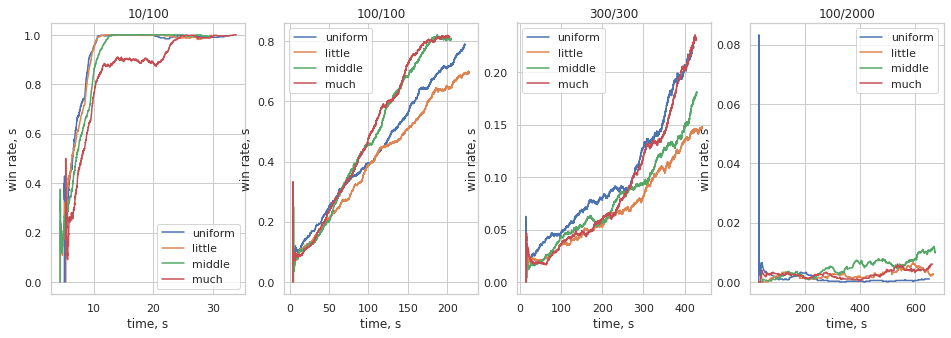

In [100]:
plot_results(tasks_results, 'sampling_warm')

In [101]:
! cp -n *.svg /content/drive/MyDrive/wordle-rl/tests

## Rewards

In [16]:
def experiment(rewards, answers, guesses, n_episodes, nickname, logging_level=None):
    env = Environment(
        rewards=rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        state_instance=StateYesNo()
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        replay_buffer=PrioritizedReplayBuffer(state_size=env.state.size)
    )

    res = train(
        env=env, agent=agent, nickname=nickname,
        n_episodes=n_episodes, logging_level=logging_level
    )
    test(env=env, agent=agent)
    return res

In [17]:
tasks_results = defaultdict(dict)
nickname = 'rewards'

### Soft

In [18]:
res = experiment(soft_rewards, answers_10_100, guesses_10_100, 5000, 'soft')
tasks_results['10/100']['soft'] = res

Playing 500 initial games (warm start)... Collected! Time: 7.7 s

Episode  500	Score: 9.18	Success Rate: 54.0%	RMSE: 178.171	Time: 12.7 s

Episode 1000	Score: 20.31	Success Rate: 88.2%	RMSE: 171.060	Time: 16.9 s

Episode 1500	Score: 22.00	Success Rate: 92.6%	RMSE: 168.985	Time: 20.4 s

Episode 2000	Score: 23.16	Success Rate: 93.4%	RMSE: 171.522	Time: 24.3 s

Episode 2500	Score: 21.91	Success Rate: 89.0%	RMSE: 241.208	Time: 29.7 s

Episode 3000	Score: 21.68	Success Rate: 88.8%	RMSE: 171.081	Time: 34.6 s

Episode 3500	Score: 22.63	Success Rate: 89.6%	RMSE: 147.364	Time: 39.9 s

Episode 4000	Score: 23.10	Success Rate: 91.2%	RMSE: 234.211	Time: 45.9 s

Episode 4500	Score: 23.80	Success Rate: 92.2%	RMSE: 195.092	Time: 51.2 s

Episode 5000	Score: 25.16	Success Rate: 94.2%	RMSE: 196.826	Time: 57.4 s

Saving checkpoint... Saved to soft-1-21-03-2023-11:37:51.pth

Success: 9 / 10 (90.0000%)	Steps: 4.6667	Time: 0.0 s	Saved to: test21-03-2023-11:38:49.txt



In [19]:
res = experiment(soft_rewards, answers_100_100, guesses_100_100, 20000, 'soft')
tasks_results['100/100']['soft'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.5 s

Episode 2000	Score: -2.67	Success Rate: 17.8%	RMSE: 236.112	Time: 30.5 s

Episode 4000	Score: 3.36	Success Rate: 34.2%	RMSE: 208.909	Time: 55.3 s

Saving checkpoint... Saved to soft-1-21-03-2023-11:38:49.pth

Episode 6000	Score: 6.48	Success Rate: 43.7%	RMSE: 292.561	Time: 78.5 s

Episode 8000	Score: 9.22	Success Rate: 51.4%	RMSE: 284.811	Time: 102.5 s

Episode 10000	Score: 10.28	Success Rate: 54.9%	RMSE: 293.174	Time: 126.3 s

Saving checkpoint... Saved to soft-2-21-03-2023-11:38:49.pth

Episode 12000	Score: 12.74	Success Rate: 61.4%	RMSE: 382.436	Time: 148.8 s

Episode 14000	Score: 13.01	Success Rate: 62.4%	RMSE: 304.816	Time: 171.8 s

Saving checkpoint... Saved to soft-3-21-03-2023-11:38:49.pth

Episode 16000	Score: 15.53	Success Rate: 70.5%	RMSE: 339.722	Time: 194.3 s

Episode 18000	Score: 16.16	Success Rate: 72.3%	RMSE: 311.041	Time: 216.2 s

Episode 20000	Score: 17.08	Success Rate: 74.9%	RMSE: 305.011	Time: 239.1 s

In [20]:
with open(nickname + '.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Hard

In [21]:
res = experiment(hard_rewards, answers_10_100, guesses_10_100, 5000, 'hard')
tasks_results['10/100']['hard'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.6 s

Episode  500	Score: -1.59	Success Rate: 70.6%	RMSE: 91.845	Time: 9.4 s

Episode 1000	Score: 7.57	Success Rate: 100.0%	RMSE: 128.200	Time: 12.0 s

Episode 1500	Score: 7.87	Success Rate: 100.0%	RMSE: 100.922	Time: 14.4 s

Episode 2000	Score: 7.78	Success Rate: 99.2%	RMSE: 116.158	Time: 16.7 s

Episode 2500	Score: 7.91	Success Rate: 99.6%	RMSE: 72.128	Time: 19.3 s

Episode 3000	Score: 6.56	Success Rate: 94.8%	RMSE: 78.913	Time: 22.4 s

Episode 3500	Score: 7.48	Success Rate: 98.4%	RMSE: 166.796	Time: 24.8 s

Episode 4000	Score: 6.17	Success Rate: 93.6%	RMSE: 83.619	Time: 27.5 s

Episode 4500	Score: 5.64	Success Rate: 92.2%	RMSE: 143.999	Time: 30.2 s

Episode 5000	Score: 5.53	Success Rate: 92.6%	RMSE: 64.119	Time: 33.4 s

Saving checkpoint... Saved to hard-1-21-03-2023-11:42:49.pth

Success: 10 / 10 (100.0000%)	Steps: 2.0000	Time: 0.0 s	Saved to: test21-03-2023-11:43:23.txt



In [22]:
res = experiment(hard_rewards, answers_100_100, guesses_100_100, 20000, 'hard')
tasks_results['100/100']['hard'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.9 s

Episode 2000	Score: -17.32	Success Rate: 10.5%	RMSE: 93.438	Time: 31.6 s

Episode 4000	Score: -14.31	Success Rate: 22.4%	RMSE: 135.826	Time: 57.6 s

Saving checkpoint... Saved to hard-1-21-03-2023-11:43:23.pth

Episode 6000	Score: -11.83	Success Rate: 32.7%	RMSE: 207.597	Time: 81.9 s

Episode 8000	Score: -10.03	Success Rate: 39.7%	RMSE: 203.721	Time: 105.9 s

Episode 10000	Score: -8.55	Success Rate: 45.5%	RMSE: 247.262	Time: 129.4 s

Saving checkpoint... Saved to hard-2-21-03-2023-11:43:23.pth

Episode 12000	Score: -7.66	Success Rate: 49.6%	RMSE: 214.728	Time: 152.8 s

Episode 14000	Score: -6.86	Success Rate: 53.0%	RMSE: 270.198	Time: 175.5 s

Saving checkpoint... Saved to hard-3-21-03-2023-11:43:23.pth

Episode 16000	Score: -5.15	Success Rate: 59.9%	RMSE: 206.676	Time: 198.1 s

Episode 18000	Score: -4.64	Success Rate: 62.5%	RMSE: 271.697	Time: 220.0 s

Episode 20000	Score: -3.42	Success Rate: 67.5%	RMSE: 276.443	Time: 2

In [23]:
with open(nickname + '.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Step

In [24]:
res = experiment(step_rewards, answers_10_100, guesses_10_100, 5000, 'step')
tasks_results['10/100']['step'] = res

Playing 500 initial games (warm start)... Collected! Time: 5.0 s

Episode  500	Score: -8.03	Success Rate: 66.0%	RMSE: 185.484	Time: 9.5 s

Episode 1000	Score: 5.98	Success Rate: 98.6%	RMSE: 88.748	Time: 12.0 s

Episode 1500	Score: 7.03	Success Rate: 100.0%	RMSE: 131.567	Time: 14.1 s

Episode 2000	Score: 7.04	Success Rate: 99.8%	RMSE: 118.566	Time: 16.3 s

Episode 2500	Score: 6.81	Success Rate: 99.4%	RMSE: 117.573	Time: 19.0 s

Episode 3000	Score: 7.05	Success Rate: 100.0%	RMSE: 83.640	Time: 21.8 s

Episode 3500	Score: 6.74	Success Rate: 99.8%	RMSE: 62.615	Time: 24.0 s

Episode 4000	Score: 6.68	Success Rate: 99.6%	RMSE: 90.589	Time: 26.4 s

Episode 4500	Score: 7.00	Success Rate: 99.8%	RMSE: 86.048	Time: 28.6 s

Episode 5000	Score: 6.75	Success Rate: 99.6%	RMSE: 64.183	Time: 30.8 s

Saving checkpoint... Saved to step-1-21-03-2023-11:47:26.pth

Success: 10 / 10 (100.0000%)	Steps: 1.9000	Time: 0.0 s	Saved to: test21-03-2023-11:47:57.txt



In [25]:
res = experiment(step_rewards, answers_100_100, guesses_100_100, 20000, 'step')
tasks_results['100/100']['step'] = res

Playing 500 initial games (warm start)... Collected! Time: 5.5 s

Episode 2000	Score: -26.86	Success Rate: 13.1%	RMSE: 250.945	Time: 31.8 s

Episode 4000	Score: -24.07	Success Rate: 21.2%	RMSE: 271.349	Time: 58.0 s

Saving checkpoint... Saved to step-1-21-03-2023-11:47:57.pth

Episode 6000	Score: -21.24	Success Rate: 30.0%	RMSE: 231.645	Time: 83.5 s

Episode 8000	Score: -17.43	Success Rate: 41.9%	RMSE: 301.573	Time: 107.9 s

Episode 10000	Score: -14.71	Success Rate: 50.4%	RMSE: 252.990	Time: 135.7 s

Saving checkpoint... Saved to step-2-21-03-2023-11:47:57.pth

Episode 12000	Score: -11.80	Success Rate: 58.6%	RMSE: 285.975	Time: 158.1 s

Episode 14000	Score: -9.68	Success Rate: 64.0%	RMSE: 315.488	Time: 178.8 s

Saving checkpoint... Saved to step-3-21-03-2023-11:47:57.pth

Episode 16000	Score: -8.24	Success Rate: 68.5%	RMSE: 256.385	Time: 200.2 s

Episode 18000	Score: -6.87	Success Rate: 73.2%	RMSE: 269.684	Time: 219.6 s

Episode 20000	Score: -5.41	Success Rate: 76.7%	RMSE: 310.033	Time

In [26]:
with open(nickname + '.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Char

In [27]:
res = experiment(char_rewards, answers_10_100, guesses_10_100, 5000, 'char')
tasks_results['10/100']['char'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.5 s

Episode  500	Score: -1.37	Success Rate: 58.4%	RMSE: 150.329	Time: 8.8 s

Episode 1000	Score: 6.43	Success Rate: 86.2%	RMSE: 101.660	Time: 12.8 s

Episode 1500	Score: 7.32	Success Rate: 88.2%	RMSE: 94.134	Time: 15.9 s

Episode 2000	Score: 5.55	Success Rate: 82.4%	RMSE: 147.621	Time: 19.4 s

Episode 2500	Score: 6.50	Success Rate: 87.8%	RMSE: 197.726	Time: 23.0 s

Episode 3000	Score: 6.33	Success Rate: 88.4%	RMSE: 112.162	Time: 27.8 s

Episode 3500	Score: 7.48	Success Rate: 92.4%	RMSE: 147.782	Time: 31.6 s

Episode 4000	Score: 6.36	Success Rate: 88.4%	RMSE: 212.583	Time: 35.6 s

Episode 4500	Score: 5.54	Success Rate: 87.0%	RMSE: 191.809	Time: 40.8 s

Episode 5000	Score: 6.87	Success Rate: 93.0%	RMSE: 215.033	Time: 45.2 s

Saving checkpoint... Saved to char-1-21-03-2023-11:51:57.pth

Success: 9 / 10 (90.0000%)	Steps: 3.7778	Time: 0.0 s	Saved to: test21-03-2023-11:52:42.txt



In [28]:
res = experiment(char_rewards, answers_100_100, guesses_100_100, 20000, 'char')
tasks_results['100/100']['char'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.5 s

Episode 2000	Score: -12.32	Success Rate: 15.0%	RMSE: 175.916	Time: 31.2 s

Episode 4000	Score: -8.90	Success Rate: 28.7%	RMSE: 173.088	Time: 57.2 s

Saving checkpoint... Saved to char-1-21-03-2023-11:52:43.pth

Episode 6000	Score: -6.55	Success Rate: 38.9%	RMSE: 183.351	Time: 82.3 s

Episode 8000	Score: -3.80	Success Rate: 50.0%	RMSE: 213.578	Time: 106.6 s

Episode 10000	Score: -3.05	Success Rate: 53.8%	RMSE: 221.129	Time: 129.7 s

Saving checkpoint... Saved to char-2-21-03-2023-11:52:43.pth

Episode 12000	Score: -2.25	Success Rate: 57.5%	RMSE: 198.786	Time: 153.8 s

Episode 14000	Score: -0.49	Success Rate: 64.3%	RMSE: 213.817	Time: 176.8 s

Saving checkpoint... Saved to char-3-21-03-2023-11:52:43.pth

Episode 16000	Score: -0.24	Success Rate: 65.8%	RMSE: 221.120	Time: 199.0 s

Episode 18000	Score: -0.27	Success Rate: 66.0%	RMSE: 265.658	Time: 222.1 s

Episode 20000	Score: 0.84	Success Rate: 70.7%	RMSE: 212.388	Time: 244.

In [29]:
with open(nickname + '.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Plot Results

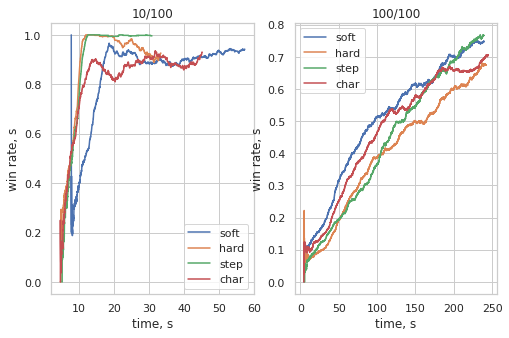

In [30]:
plot_results(tasks_results, nickname)

In [31]:
! cp -n *.svg /content/drive/MyDrive/wordle-rl/tests

## States

In [32]:
tasks_results = defaultdict(dict)
nickname = 'state'

### StateYesNo

In [33]:
def experiment(answers, guesses, n_episodes, logging_level=None):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        # here is what we are experimenting with
        state_instance=StateYesNo()
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        replay_buffer=PrioritizedReplayBuffer(state_size=env.state.size)
    )

    res = train(
        env=env, agent=agent, nickname='yesno',
        n_episodes=n_episodes, logging_level=logging_level
    )
    test(env=env, agent=agent)
    return res

In [34]:
res = experiment(answers_10_100, guesses_10_100, 5000)
tasks_results['10/100']['yesno'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.6 s

Episode  500	Score: -7.15	Success Rate: 71.2%	RMSE: 128.533	Time: 9.1 s

Episode 1000	Score: 4.63	Success Rate: 98.6%	RMSE: 111.610	Time: 12.2 s

Episode 1500	Score: 6.50	Success Rate: 100.0%	RMSE: 140.448	Time: 14.6 s

Episode 2000	Score: 6.67	Success Rate: 100.0%	RMSE: 134.571	Time: 16.9 s

Episode 2500	Score: 6.57	Success Rate: 99.6%	RMSE: 113.270	Time: 19.3 s

Episode 3000	Score: 6.70	Success Rate: 100.0%	RMSE: 89.728	Time: 21.8 s

Episode 3500	Score: 6.42	Success Rate: 99.8%	RMSE: 90.130	Time: 25.0 s

Episode 4000	Score: 6.60	Success Rate: 100.0%	RMSE: 81.406	Time: 27.4 s

Episode 4500	Score: 5.36	Success Rate: 97.8%	RMSE: 78.920	Time: 30.0 s

Episode 5000	Score: 6.15	Success Rate: 98.8%	RMSE: 98.404	Time: 32.4 s

Saving checkpoint... Saved to yesno-1-21-03-2023-11:56:50.pth

Success: 10 / 10 (100.0000%)	Steps: 2.4000	Time: 0.0 s	Saved to: test21-03-2023-11:57:23.txt



In [35]:
res = experiment(answers_50_200, guesses_50_200, 20000)
tasks_results['50/200']['yesno'] = res

Playing 500 initial games (warm start)... Collected! Time: 5.5 s

Episode 2000	Score: -24.86	Success Rate: 19.2%	RMSE: 249.155	Time: 31.0 s

Episode 4000	Score: -20.09	Success Rate: 33.1%	RMSE: 214.819	Time: 55.3 s

Saving checkpoint... Saved to yesno-1-21-03-2023-11:57:23.pth

Episode 6000	Score: -16.40	Success Rate: 43.8%	RMSE: 285.534	Time: 78.7 s

Episode 8000	Score: -11.55	Success Rate: 58.5%	RMSE: 325.758	Time: 99.4 s

Episode 10000	Score: -8.29	Success Rate: 66.8%	RMSE: 279.598	Time: 119.9 s

Saving checkpoint... Saved to yesno-2-21-03-2023-11:57:23.pth

Episode 12000	Score: -5.92	Success Rate: 72.4%	RMSE: 334.337	Time: 137.9 s

Episode 14000	Score: -4.19	Success Rate: 79.5%	RMSE: 291.382	Time: 156.0 s

Saving checkpoint... Saved to yesno-3-21-03-2023-11:57:23.pth

Episode 16000	Score: -0.39	Success Rate: 87.1%	RMSE: 238.146	Time: 172.3 s

Episode 18000	Score: 1.41	Success Rate: 91.3%	RMSE: 254.714	Time: 187.3 s

Episode 20000	Score: 1.42	Success Rate: 91.5%	RMSE: 285.640	Time: 

In [36]:
with open(nickname + '.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### StateVocabulary

In [37]:
def experiment(answers, guesses, n_episodes, logging_level=None):
    env = Environment(
        rewards=step_rewards,
        wordle=Wordle(vocabulary=guesses, answers=answers),
        # here is what we are experimenting with
        state_instance=StateVocabulary(
            answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
        )
    )

    agent = Agent(
        state_size=env.state.size,
        action_size=len(guesses),
        action_constructor=partial(ActionVocabulary, vocabulary=guesses),
        replay_buffer=PrioritizedReplayBuffer(state_size=env.state.size)
    )

    res = train(
        env=env, agent=agent, nickname='vocab',
        n_episodes=n_episodes, logging_level=logging_level
    )
    test(env=env, agent=agent)
    return res

In [38]:
res = experiment(answers_10_100, guesses_10_100, 5000)
tasks_results['10/100']['vocab'] = res

Playing 500 initial games (warm start)... Collected! Time: 4.7 s

Episode  500	Score: -4.96	Success Rate: 76.0%	RMSE: 137.787	Time: 9.1 s

Episode 1000	Score: 6.52	Success Rate: 100.0%	RMSE: 121.088	Time: 12.1 s

Episode 1500	Score: 6.98	Success Rate: 100.0%	RMSE: 126.901	Time: 14.4 s

Episode 2000	Score: 7.07	Success Rate: 100.0%	RMSE: 122.026	Time: 16.7 s

Episode 2500	Score: 7.01	Success Rate: 100.0%	RMSE: 100.369	Time: 19.0 s

Episode 3000	Score: 6.94	Success Rate: 99.8%	RMSE: 96.328	Time: 21.3 s

Episode 3500	Score: 6.89	Success Rate: 99.8%	RMSE: 68.610	Time: 24.3 s

Episode 4000	Score: 6.17	Success Rate: 98.0%	RMSE: 79.313	Time: 26.8 s

Episode 4500	Score: 6.81	Success Rate: 99.6%	RMSE: 87.706	Time: 29.1 s

Episode 5000	Score: 5.96	Success Rate: 98.2%	RMSE: 65.680	Time: 31.6 s

Saving checkpoint... Saved to vocab-1-21-03-2023-12:00:46.pth

Success: 10 / 10 (100.0000%)	Steps: 1.9000	Time: 0.0 s	Saved to: test21-03-2023-12:01:18.txt



In [39]:
res = experiment(answers_50_200, guesses_50_200, 20000)
tasks_results['50/200']['vocab'] = res

Playing 500 initial games (warm start)... Collected! Time: 5.4 s

Episode 2000	Score: -24.69	Success Rate: 19.7%	RMSE: 269.889	Time: 31.5 s

Episode 4000	Score: -20.96	Success Rate: 31.1%	RMSE: 245.485	Time: 57.2 s

Saving checkpoint... Saved to vocab-1-21-03-2023-12:01:18.pth

Episode 6000	Score: -15.71	Success Rate: 45.9%	RMSE: 264.458	Time: 81.7 s

Episode 8000	Score: -13.09	Success Rate: 53.1%	RMSE: 323.006	Time: 104.5 s

Episode 10000	Score: -11.60	Success Rate: 58.4%	RMSE: 362.139	Time: 125.7 s

Saving checkpoint... Saved to vocab-2-21-03-2023-12:01:18.pth

Episode 12000	Score: -8.90	Success Rate: 65.2%	RMSE: 291.693	Time: 146.7 s

Episode 14000	Score: -5.55	Success Rate: 74.6%	RMSE: 293.771	Time: 165.3 s

Saving checkpoint... Saved to vocab-3-21-03-2023-12:01:18.pth

Episode 16000	Score: -2.40	Success Rate: 81.5%	RMSE: 282.489	Time: 182.0 s

Episode 18000	Score: -0.99	Success Rate: 85.1%	RMSE: 262.322	Time: 198.7 s

Episode 20000	Score: -0.81	Success Rate: 86.2%	RMSE: 295.449	Ti

In [40]:
with open(nickname + '.pickle', 'wb') as handle:
    pickle.dump(tasks_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pickle /content/drive/MyDrive/wordle-rl/tests

### Plot Results

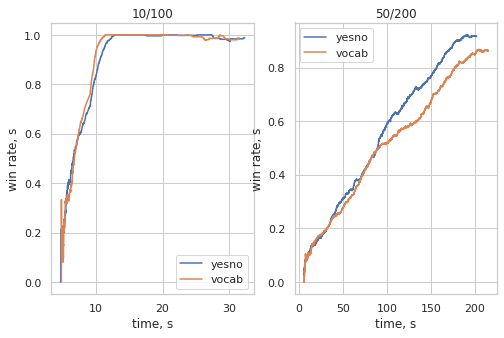

In [41]:
plot_results(tasks_results, nickname)

## Steps

Здесь используем оптимальные параметры с предыдущих экспериментов.

### 6 on train, 6 on test

In [ ]:
def experiment(answers, guesses, n_episodes, logging_level=None):
  env = Environment(
    rewards=step_rewards,
    wordle=Wordle(vocabulary=guesses, answers=answers),
    state_instance=StateVocabulary(
        answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
    )
  )

  agent = Agent(
    state_size=env.state.size,
    action_size=len(guesses),
    action_constructor=partial(ActionVocabulary, vocabulary=guesses)
  )

  train(env=env, agent=agent, n_episodes=n_episodes, logging_level=logging_level)
  test(env=env, agent=agent)

In [ ]:
experiment(answers_10_100, guesses_10_100, 5000)

In [ ]:
experiment(answers_100_100, guesses_100_100, 20000)

In [ ]:
experiment(answers_100_2000, guesses_100_2000, 40000)

In [ ]:
! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

### 10 on train, 6 on test

In [ ]:
def experiment(answers, guesses, n_episodes, logging_level=None):
  env = Environment(
    rewards=step_rewards,
    wordle=Wordle(vocabulary=guesses, answers=answers, max_guesses=10), # here is what we are experimenting with
    state_instance=StateVocabulary(
        answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
    )
  )

  agent = Agent(
    state_size=env.state.size,
    action_size=len(guesses),
    action_constructor=partial(ActionVocabulary, vocabulary=guesses),
  )

  train(env=env, agent=agent, n_episodes=n_episodes, logging_level=logging_level)
  env.wordle.max_guesses = 6 
  test(env=env, agent=agent)

In [ ]:
experiment(answers_10_100, guesses_10_100, 5000)

In [ ]:
experiment(answers_100_100, guesses_100_100, 20000)

In [ ]:
experiment(answers_100_2000, guesses_100_2000, 40000)

In [ ]:
! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

### 15 on train, 6 on test

In [ ]:
def experiment(answers, guesses, n_episodes, logging_level=None):
  env = Environment(
    rewards=step_rewards,
    wordle=Wordle(vocabulary=guesses, answers=answers, max_guesses=15), # here is what we are experimenting with
    state_instance=StateVocabulary(
        answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
    )
  )

  agent = Agent(
    state_size=env.state.size,
    action_size=len(env.wordle.vocabulary),
    action_constructor=partial(ActionVocabulary, vocabulary=guesses),
  )

  train(env=env, agent=agent, n_episodes=n_episodes, logging_level=logging_level)
  env.wordle.max_guesses = 6
  test(env=env, agent=agent)

In [ ]:
experiment(answers_10_100, guesses_10_100, 5000)

In [ ]:
experiment(answers_100_100, guesses_100_100, 20000)

In [ ]:
! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [ ]:
experiment(answers_100_2000, guesses_100_2000, 40000)

In [ ]:
! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

### stages on steps number

Появилась идея: сначала обучить на 6, затем на 10, и наконец на 15.

In [ ]:
def steps_stage_train(answers, guesses, episodes_counts:dict):
  env = Environment(
    rewards=step_rewards,
    wordle=Wordle(vocabulary=guesses, answers=answers),
    state_instance=StateVocabulary(
        answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
    )
  )

  agent = Agent(
    state_size=env.state.size,
    action_size=len(guesses),
    action_constructor=partial(ActionVocabulary, vocabulary=guesses),
  )

  for steps, n_episodes in episodes_counts.items():
    env.wordle.max_guesses = steps  # here is what we are experimenting with
    train(env=env, agent=agent, n_episodes=n_episodes)
    env.wordle.max_guesses = 6
    test(env=env, agent=agent)

In [ ]:
episodes_counts = {6: 15000, 10: 4000, 15: 1000}
steps_stage_train(answers_100_100, guesses_100_100, episodes_counts)

In [ ]:
! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

In [ ]:
episodes_counts = {6: 30000, 10: 7000, 15: 3000}
steps_stage_train(answers_100_2000, guesses_100_2000, episodes_counts)

In [ ]:
! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests

## Stages on answers list size

Фиксированный guesses размера 100. Меняющийся answers по порядку: 10, 40, 70, 100.

In [ ]:
def answer_stage_train(
    full_answers, guesses, start_size, end_size, n_stages, episodes_counts
  ):
  agent = Agent(
    state_size=StateYesNo().size + 100,
    action_size=len(guesses),
    action_constructor=partial(ActionVocabulary, vocabulary=guesses),
  )

  for i in range(n_stages):
    t = i / (n_stages - 1)
    size = start_size * (1 - t) + end_size * t
    answers = full_answers[:size]

    env = Environment(
      rewards=step_rewards,
      wordle=Wordle(
          vocabulary=guesses,
          answers=answers
      ),
      state_instance=StateVocabulary(
          answers_mask=np.fromiter((g in answers for g in guesses), dtype=bool)
      )
    )

    train(env=env, agent=agent, n_episodes=episodes_counts[i])
    test(env=env, agent=agent)
    print('\n============================')

In [ ]:
answer_stage_train(
    full_answers=answers_100_2000,
    guesses=guesses_100_2000,
    start_size=30,
    end_size=100,
    n_stages=3,
    episodes_counts=[10000, 10000, 20000]
)

In [ ]:
! cp -n *.txt /content/drive/MyDrive/wordle-rl/tests
! cp -n *.pth /content/drive/MyDrive/wordle-rl/tests